In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
import warnings
warnings.filterwarnings('ignore')

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_33646/2489172623.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
import src.helpers.simulate_foci as simulate_foci
import src.helpers.simulate_cells as simulate_cells
import src.helpers.condensate_movement as condensate_movement
import src.helpers.fbm_utility as fbm_utility
import src.helpers.probability_functions as probability_functions
import src.helpers.blob_detection as blobs

import numpy as np
import matplotlib.pyplot as plt
#import copy
import copy as copy

Create a proof of concept of 2 condensates defined by points

In [61]:
condensate_initials = {
    "initial_centers": np.array([[5.5,5.5],[9.5,9.5]]),
    "initial_scale": np.array([1,1]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.1,0.1])
}
cell_initials = {
    "space_size": np.array([1,15]),
    "density_dif": 5*1e0,
    "total_points": 500 #placeholder to change for each condition
}



In [62]:
sim = simulate_foci.sim_foci(max_x = 20,
                        min_x = 0,
                        radius = 1,
                        center = [7.,7.],
                        total_points = cell_initials['total_points'],
                        density_dif = 5.0,
                        pdf = simulate_foci.tophat_function_2d,
                        point_intensity = 40,
                        projection_frames = 1000)
sim.uniform_blob = False
sim.psf_sigma = 0.82
sim.base_noise = 140
sim.create_condensate_dict(**condensate_initials,units_time=np.array(["20ms"]*len(condensate_initials['diffusion_coefficient'])))
#define the top_hat class that will be used to sample the condensates
top_hat_func = probability_functions.multiple_top_hat_probability(
    num_subspace = len(condensate_initials['diffusion_coefficient']),
    subspace_centers = condensate_initials['initial_centers'],
    subspace_radius = condensate_initials['initial_scale'],
    density_dif = cell_initials['density_dif'],
    space_size = np.array([15,15]),
)

#make a placeholder for the initial position array with all 0s
initials = np.zeros((cell_initials['total_points'],2))
for i in range(len(initials)):
    #lets use the starting frames to find the inital position based on the position of the condensates
    #get the starting frame
    starting_frame = 1
    #condensate positions
    condensate_positions = np.zeros((len(sim.condensates),2))
    #loop through the condensates
    for ID,cond in sim.condensates.items():
        condensate_positions[int(ID)] = cond(int(starting_frame),"20ms")["Position"]
    #update the top_hat_func with the new condensate positions
    top_hat_func.update_parameters(subspace_centers=condensate_positions)
    #sample the top hat to get the initial position
    initials[i] = simulate_foci.generate_points_from_cls(top_hat_func,total_points=1,min_x=cell_initials["space_size"][0],max_x=cell_initials["space_size"][1],density_dif=cell_initials["density_dif"])[0]

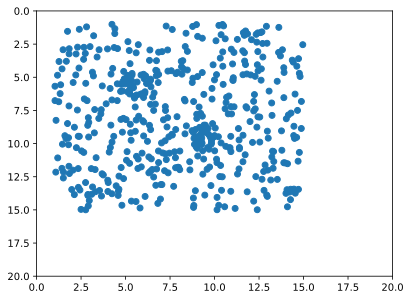

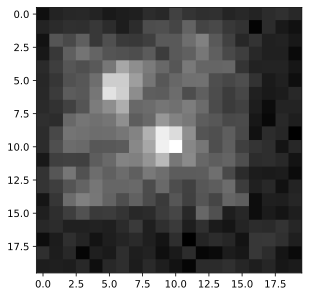

In [63]:
#plot the initial positions
plt.scatter(initials[:,0],initials[:,1])
plt.xlim(0,20)
plt.ylim(0,20)
#invert yaxis
plt.gca().invert_yaxis()
plt.show()
#make an axially varying point intensity 
#regenrate cell_initials['total_points'] numbers from a gaussian centered at sim.point_intensity and std of 10
axial_point_int = np.random.normal(loc=sim.point_intensity,scale=20,size=cell_initials['total_points'])
#replace the - values with 0
axial_point_int[axial_point_int<0] = 0
#replace values larger than sim.point_intensity with sim.point_intensity
axial_point_int[axial_point_int>sim.point_intensity] = sim.point_intensity
#make a map from this.
maped,points = sim.generate_map_from_points(points=initials,point_intensity=axial_point_int,movie=False)
plt.imshow(maped,cmap="gray")
plt.show()

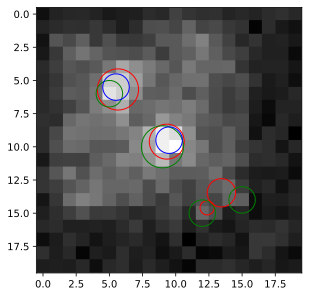

{'Fitted': array([[ 9.61111753,  9.32490908,  1.22187097,  1.41236344],
       [ 5.67911651,  5.64762504,  1.74913974,  1.35310712],
       [14.59709616, 12.36439642,  0.54356707,  0.527744  ],
       [13.46328353, 13.43965955,  0.59815597,  1.5446787 ]]), 'Scale': array([[10.        ,  9.        ,  1.58558559],
       [ 6.        ,  5.        ,  1.        ],
       [15.        , 12.        ,  1.        ],
       [14.        , 15.        ,  1.        ]]), 'Fit': [<lmfit.minimizer.MinimizerResult object at 0x29a75c4c0>, <lmfit.minimizer.MinimizerResult object at 0x29a9128c0>, <lmfit.minimizer.MinimizerResult object at 0x29a913a30>, <lmfit.minimizer.MinimizerResult object at 0x29a94ffd0>]}


In [66]:
#run blob detection on this
b = blobs.blob_detection(path = maped,\
                median= False,\
                threshold= 9e2, \
                min_sigma= 1/np.sqrt(2), \
                max_sigma = 10/np.sqrt(2), \
                num_sigma= 1000, \
                overlap = 0, \
                logscale=False,
                verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":3,
                            "plot_fit":False,
                            "fitting_image":"Original",
                            "radius_func":None,
                            "sigma_range":2,
                            "centroid_range":2})
c = b.detection(type = "bp")
#plot the image and also the detected blobs as circles
plt.imshow(maped,cmap="gray")
for i in range(len(c["Fitted"])):
    circle = plt.Circle((c["Fitted"][i][1],c["Fitted"][i][0]),np.mean([c["Fitted"][i][2],c["Fitted"][i][3]]),color="r",fill=False)
    plt.gca().add_artist(circle)
    circle_scale = plt.Circle((c["Scale"][i][1],c["Scale"][i][0]),c["Scale"][i][2],color="g",fill=False)
    plt.gca().add_artist(circle_scale)
for i,j in enumerate(condensate_initials["initial_centers"]):
    circle = plt.Circle((j[1],j[0]),condensate_initials["initial_scale"][i],color="b",fill=False)
    plt.gca().add_artist(circle) 
plt.show()

print(c)

Lets focus on changing the centers distances and see the fit

In [ ]:
condensate_initials = {
    "initial_centers": np.array([[5,5],[9,9]]),
    "initial_scale": np.array([0.5,1]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.1,0.1])
}
cell_initials = {
    "space_size": np.array([1,15]),
    "density_dif": 10,
    "total_points": 500 #placeholder to change for each condition
}


In [ ]:

condensate_positions = np.array([
    [
        [7.5,7.5],[2,2]
    ],
    [
        [7.5,7.5],[3,3]
    ],
    [
        [7.5,7.5],[4,4]
    ],
    [
        [7.5,7.5],[5,5]
    ],
    [
        [7.5,7.5],[6,6]
    ],
    [
        [7.5,7.5],[6.5,6.5]
    ],
    [
        [7.5,7.5],[7,7]
    ],
    [
        [7.5,7.5],[8,8]
    ],
    [
        [7.5,7.5],[8.5,8.5]
    ],
    [
        [7.5,7.5],[9,9]
    ],
    [
        [7.5,7.5],[10,10]
    ],
    [
        [7.5,7.5],[11,11]
    ],
    [
        [7.5,7.5],[12,12]
    ],
    [
        [7.5,7.5],[13,13]
    ],
    [
        [7.5,7.5],[14,14]
    ]
])
blobs_identified = []

for i in range(len(condensate_positions)):
    condensate_initials_i = copy.deepcopy(condensate_initials)
    condensate_initials_i["initial_centers"] = condensate_positions[i]
    sim = simulate_foci.sim_foci(max_x = 20,
                            min_x = 0,
                            radius = 1,
                            center = [7.,7.],
                            total_points = cell_initials['total_points'],
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 20,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    sim.create_condensate_dict(**condensate_initials_i,units_time=np.array(["20ms"]*len(condensate_initials_i['diffusion_coefficient'])))
    #define the top_hat class that will be used to sample the condensates
    top_hat_func = probability_functions.multiple_top_hat_probability(
        num_subspace = len(condensate_initials_i['diffusion_coefficient']),
        subspace_centers = condensate_initials_i['initial_centers'],
        subspace_radius = condensate_initials_i['initial_scale'],
        density_dif = cell_initials['density_dif'],
        space_size = np.array([15,15]),
    )

    #make a placeholder for the initial position array with all 0s
    initials = np.zeros((cell_initials["total_points"],2))
    for j in range(len(initials)):
        #lets use the starting frames to find the inital position based on the position of the condensates
        #get the starting frame
        starting_frame = 1
        #condensate positions
        condensate_positionss = np.zeros((len(sim.condensates),2))
        #loop through the condensates
        for ID,cond in sim.condensates.items():
            condensate_positionss[int(ID)] = cond(int(starting_frame),"20ms")["Position"]
        #update the top_hat_func with the new condensate positions
        top_hat_func.update_parameters(subspace_centers=condensate_positionss)
        #sample the top hat to get the initial position
        initials[j] = simulate_foci.generate_points_from_cls(top_hat_func,total_points=1,min_x=cell_initials["space_size"][0],max_x=cell_initials["space_size"][1],density_dif=cell_initials["density_dif"])[0]
    maped,points = sim.generate_map_from_points(points=initials,point_intensity=sim.point_intensity,movie=False)
    
    #plot the image
    plt.figure()
    ax = plt.subplot(111)
    #plot the image
    ax.imshow(maped,cmap="gray")
    #plot the points
    ax.scatter(points[:,1],points[:,0],color="red",s=0.5)




    b = blobs.blob_detection(path = maped,\
            median= False,\
            threshold= 8e2, \
            min_sigma= 1/np.sqrt(2), \
            max_sigma = 10/np.sqrt(2), \
            num_sigma= 1000, \
            overlap = 0.5, \
            logscale=False,
            verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":0.5,
                                "centroid_range":0.5})
    c = b.detection(type = "bp")
    blobs_identified.append(c)
    #lets plot the blobs
    for l in range(len(c["Scale"])):
        #get the circle
        circle = plt.Circle((c["Fitted"][l][1],c["Fitted"][l][0]),c["Scale"][l][2],color="red",fill=False)
        #add the circle to the plot
        ax.add_artist(circle)
    #also plot the true condensate positions
    for ID,cond in sim.condensates.items():
        circle = plt.Circle((cond(1,"20ms")["Position"][1],cond(1,"20ms")["Position"][0]),cond(1,"20ms")["Scale"],color="green",fill=False)
        ax.add_artist(circle)
    centers_0 = condensate_positions[i][0]
    centers_1 = condensate_positions[i][1]
    distances = np.sqrt((centers_0[0]-centers_1[0])**2+(centers_0[1]-centers_1[1])**2)
    #make a title with the condensate distances and the number of points used, and the density_diff
    str_title = "Condensate distance: {} \n Number of points: {} \n Density difference: {}".format(distances,len(initials),cell_initials["density_dif"])
    ax.set_title(str_title)
    #save each figure as a png in the following folder: /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/two_condensates_different_sizes
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/two_condensates_same_sizes/{}.png".format(str_title))
    plt.show()


In [ ]:
#lets plot the blobs identified
for k in blobs_identified:
    for i in k["Scale"]:
        print("blob identified: ",i)
        print("")
    print("Done")

#find the distance between the condensate_positions
distances = []
for i in range(len(condensate_positions)):
    centers_0 = condensate_positions[i][0]
    centers_1 = condensate_positions[i][1]
    distances.append(np.sqrt((centers_0[0]-centers_1[0])**2+(centers_0[1]-centers_1[1])**2))
print("distances between condensates: ",distances)

#lets plot the number of condensates identified vs the distance between the condensates
num_blobs = []
one_blob_sizes = []
two_blob_sizes = []
dist_one_blob = []
dist_two_blob = []
for i in range(len(blobs_identified)):
    if isinstance(blobs_identified[i]["Scale"],np.ndarray|list):
        num_blobs.append(len(blobs_identified[i]["Scale"]))
    else:
        num_blobs.append(1)
    if len(blobs_identified[i]["Scale"]) == 1:
        one_blob_sizes.append(blobs_identified[i]["Scale"][0][2])
        dist_one_blob.append(distances[i])
    elif len(blobs_identified[i]["Scale"]) == 2:
        two_blob_sizes.append(blobs_identified[i]["Scale"][0][2])
        two_blob_sizes.append(blobs_identified[i]["Scale"][1][2])
        dist_two_blob.append(distances[i])
        dist_two_blob.append(distances[i])
    

plt.figure()
ax = plt.subplot(111)
ax.scatter(np.array(distances)*130,num_blobs)
ax.set_xlabel("Distance between condensates (nm)")
ax.set_ylabel("Number of blobs identified")
#make 2 texts to show the average size of the blobs for one and two blobs
one_blob_text = "Average size of one blob: "+str(np.round(np.mean(one_blob_sizes)*130,2))+" nm"
two_blob_text = "Average size of two blobs: "+str(np.round(np.mean(two_blob_sizes)*130,2))+" nm"
size_simulated = "Size simulated: "+str(np.round(condensate_initials["initial_scale"]*130,2))+" nm"
ax.text(0.05,0.9,size_simulated,transform=ax.transAxes)
ax.text(0.05,0.85,one_blob_text,transform=ax.transAxes)
ax.text(0.05,0.8,two_blob_text,transform=ax.transAxes)
plt.title("Number of blobs identified vs distance between condensates")
#save the figure
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/two_condensates_same_sizes/num_blobs_vs_distance.png")
plt.show()

#plot the one blob sizes vs the one blob distances
plt.figure()
ax = plt.subplot(111)
ax.scatter(np.array(dist_one_blob)*130,np.array(one_blob_sizes)*130)
#plot the two blob sizes vs the two blob distances
ax.scatter(np.array(dist_two_blob)*130,np.array(two_blob_sizes)*130)
ax.set_xlabel("Distance between condensates (nm)")
ax.set_ylabel("Size of blobs (nm)")
plt.title("Size of blobs vs distance between condensates")
#save the figure
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/two_condensates_same_sizes/blob_size_vs_distance.png")
plt.show()


